## Change Log
- Use KL divergence in custom loss function
- determin number of bins for distributions using Freedman-Diaconis rule
- added train_val_split to config
- now using CUDA (GPU) instead of CPU (if NVIDIA Cuda available)
- save output data and models for multiple runs

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN
from scipy.special import rel_entr

## 0. Experiment Setup

In [3]:
# should an output folder be created to save the experiment data?
save_output = True

In [4]:
# read config file
import toml
config = toml.load("config.toml")

# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(sys.maxsize)
random.seed(seed_value)

# TabNet hyperparameters
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                  }

if save_output:
    # create experiment folder
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{experiment_name} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}" if experiment_name else f"Exp {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # save notebook
    shutil.copy2(nb_name, experiment_path)#
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")
    output = {}

## 1. Datasets

Different datasets are to be used for the experiments.
- toy dataset using make_blobs from sklearn mainly to setup and test the notebook
- DAMI Benchmark datasets with the respective best practice hyperparameters (https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/)
- Boston house prices

### 1.0. Create toy dataset
As of now, only a toy dataset is used (n_features features with clusters centered around different points).

In [5]:
from sklearn.datasets import make_blobs

if config["toy_data"]["use_toy_data"]:
    features_arr, clusters_arr = make_blobs(**config["toy_data"])

    # name feature and cluster (ground truth) columns
    features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
    clusters = pd.DataFrame(clusters_arr, columns=["C"])

<IPython.core.display.Javascript object>


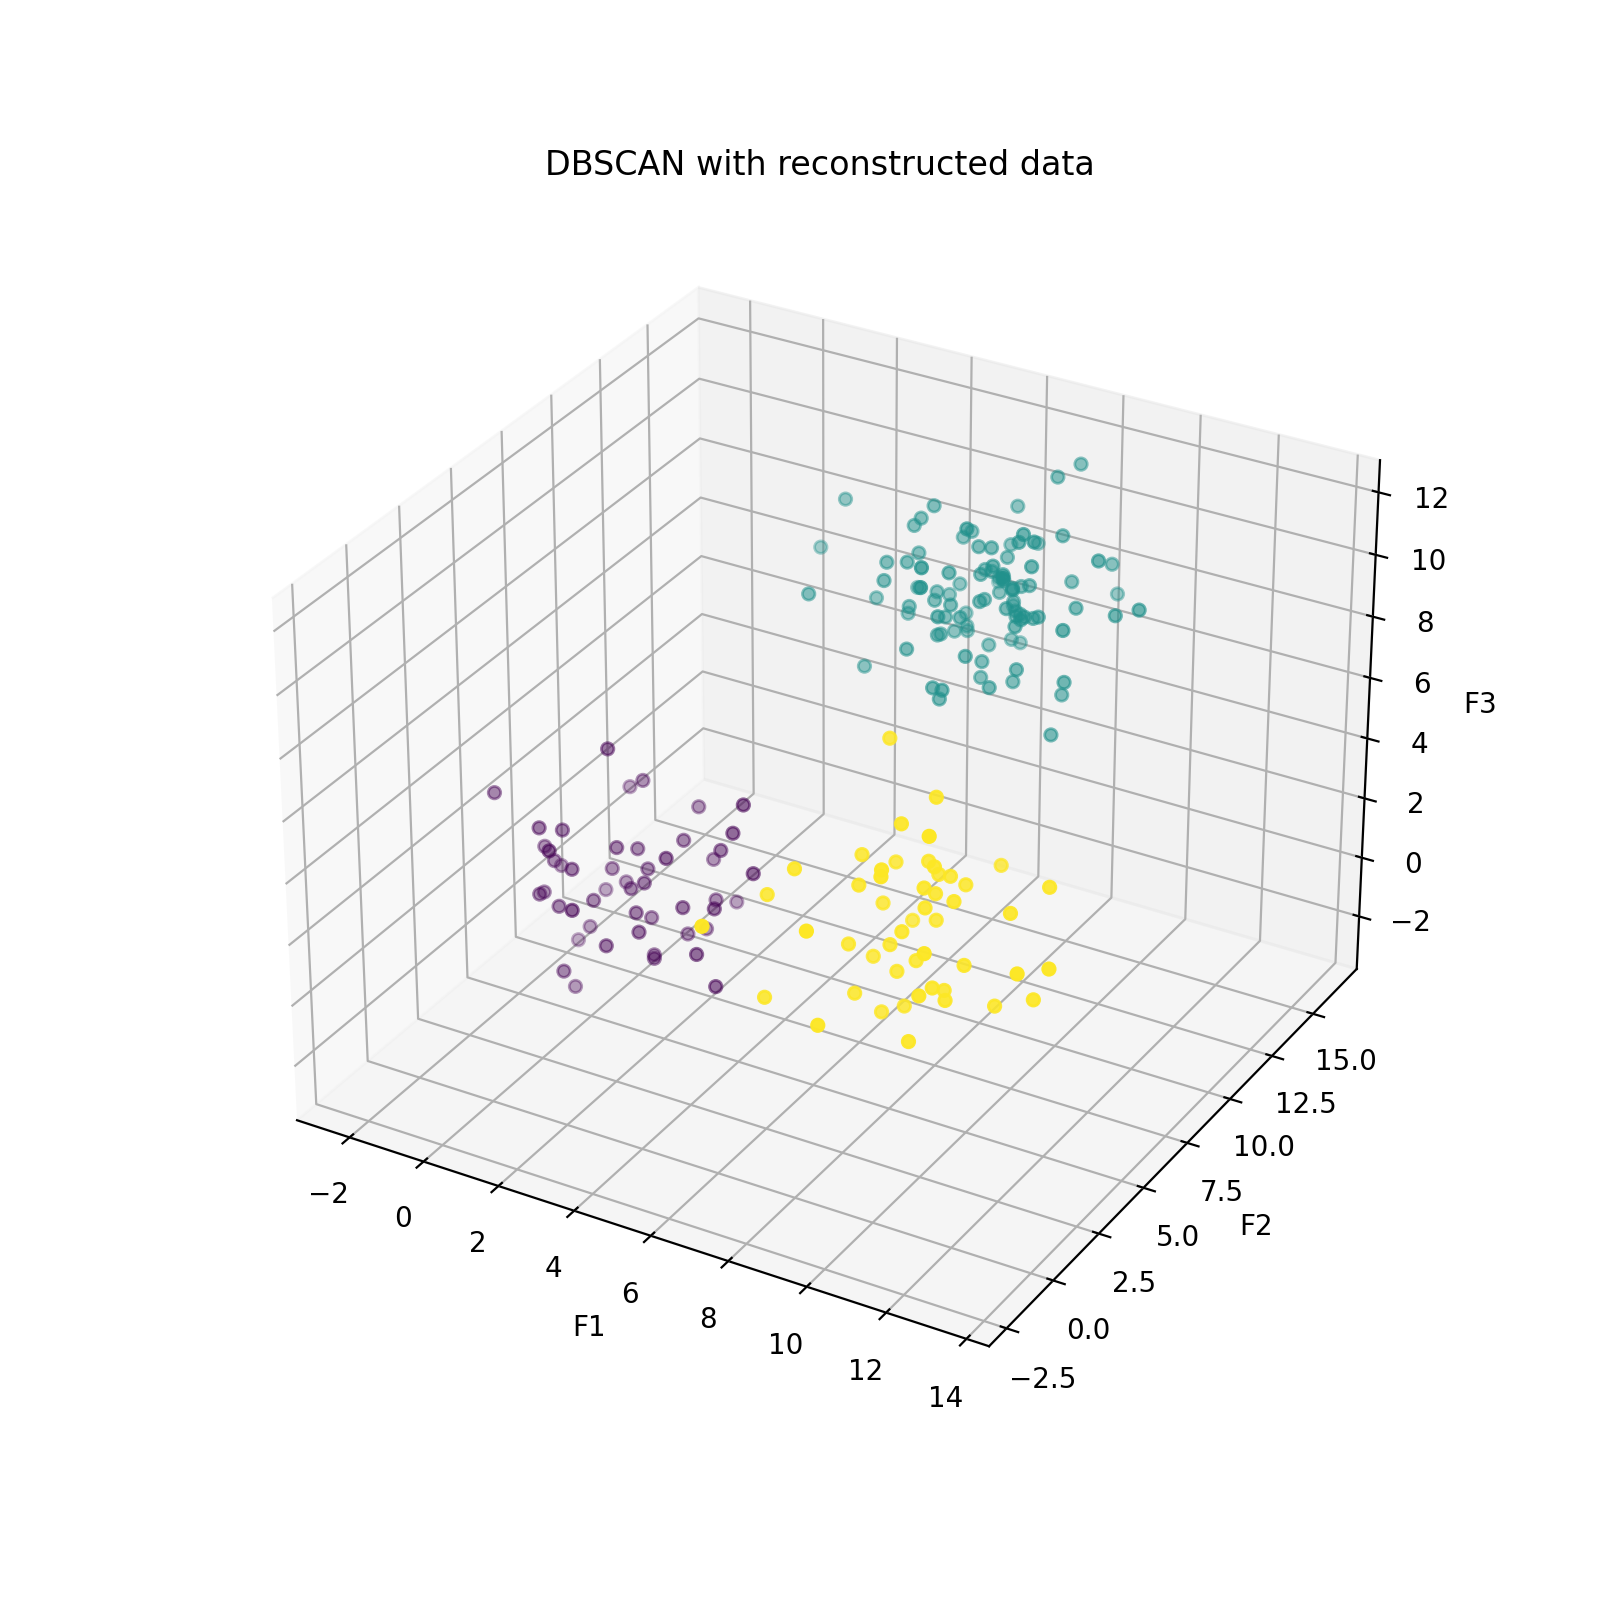

In [6]:
# plot dataset
%matplotlib notebook

if config["toy_data"]["use_toy_data"]:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
    plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
    plt.show()
    if save_output:
        plt.savefig(os.path.join(plots_path, "0_ground_truth_clusters.png"), **config["plots"])

### 1.1. Use existing datasets

In [8]:
if not config["toy_data"]["use_toy_data"]:
    features = pd.read_csv(os.path.join('Datasets', 'housing.csv'))

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [7]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), config["general"]["missing_percent"])}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

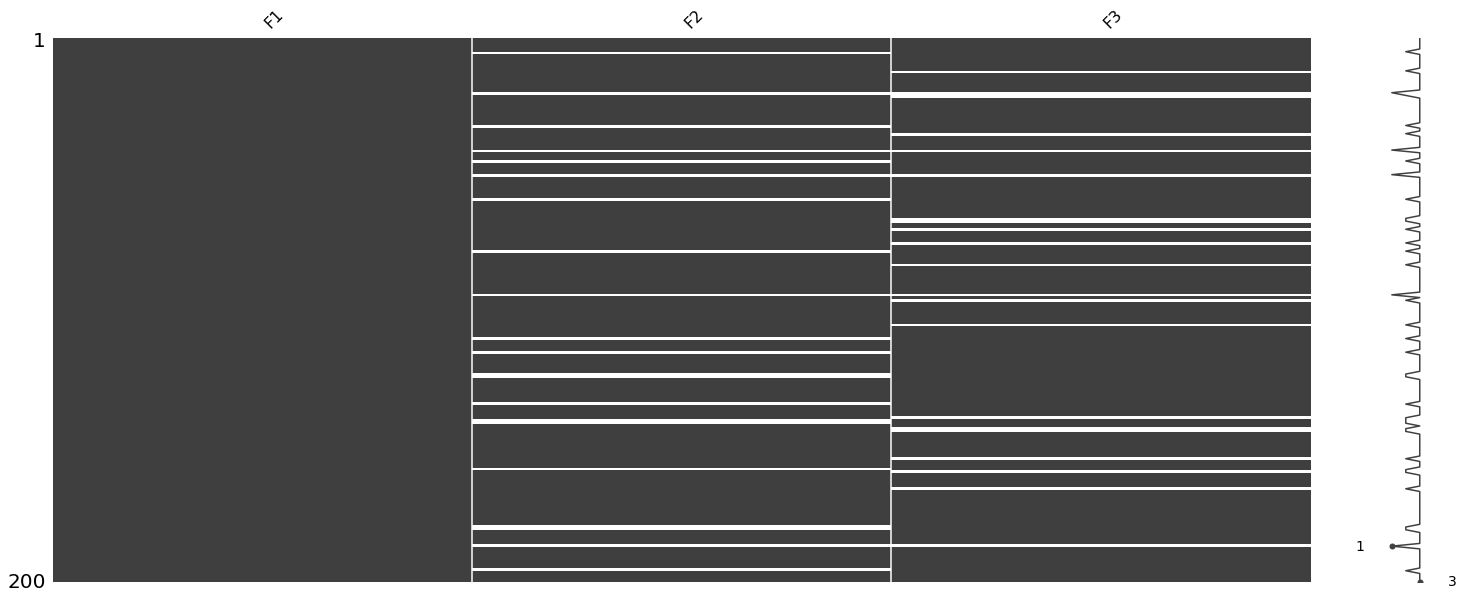

In [8]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(features_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [9]:
# run DBSCAN on original data
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


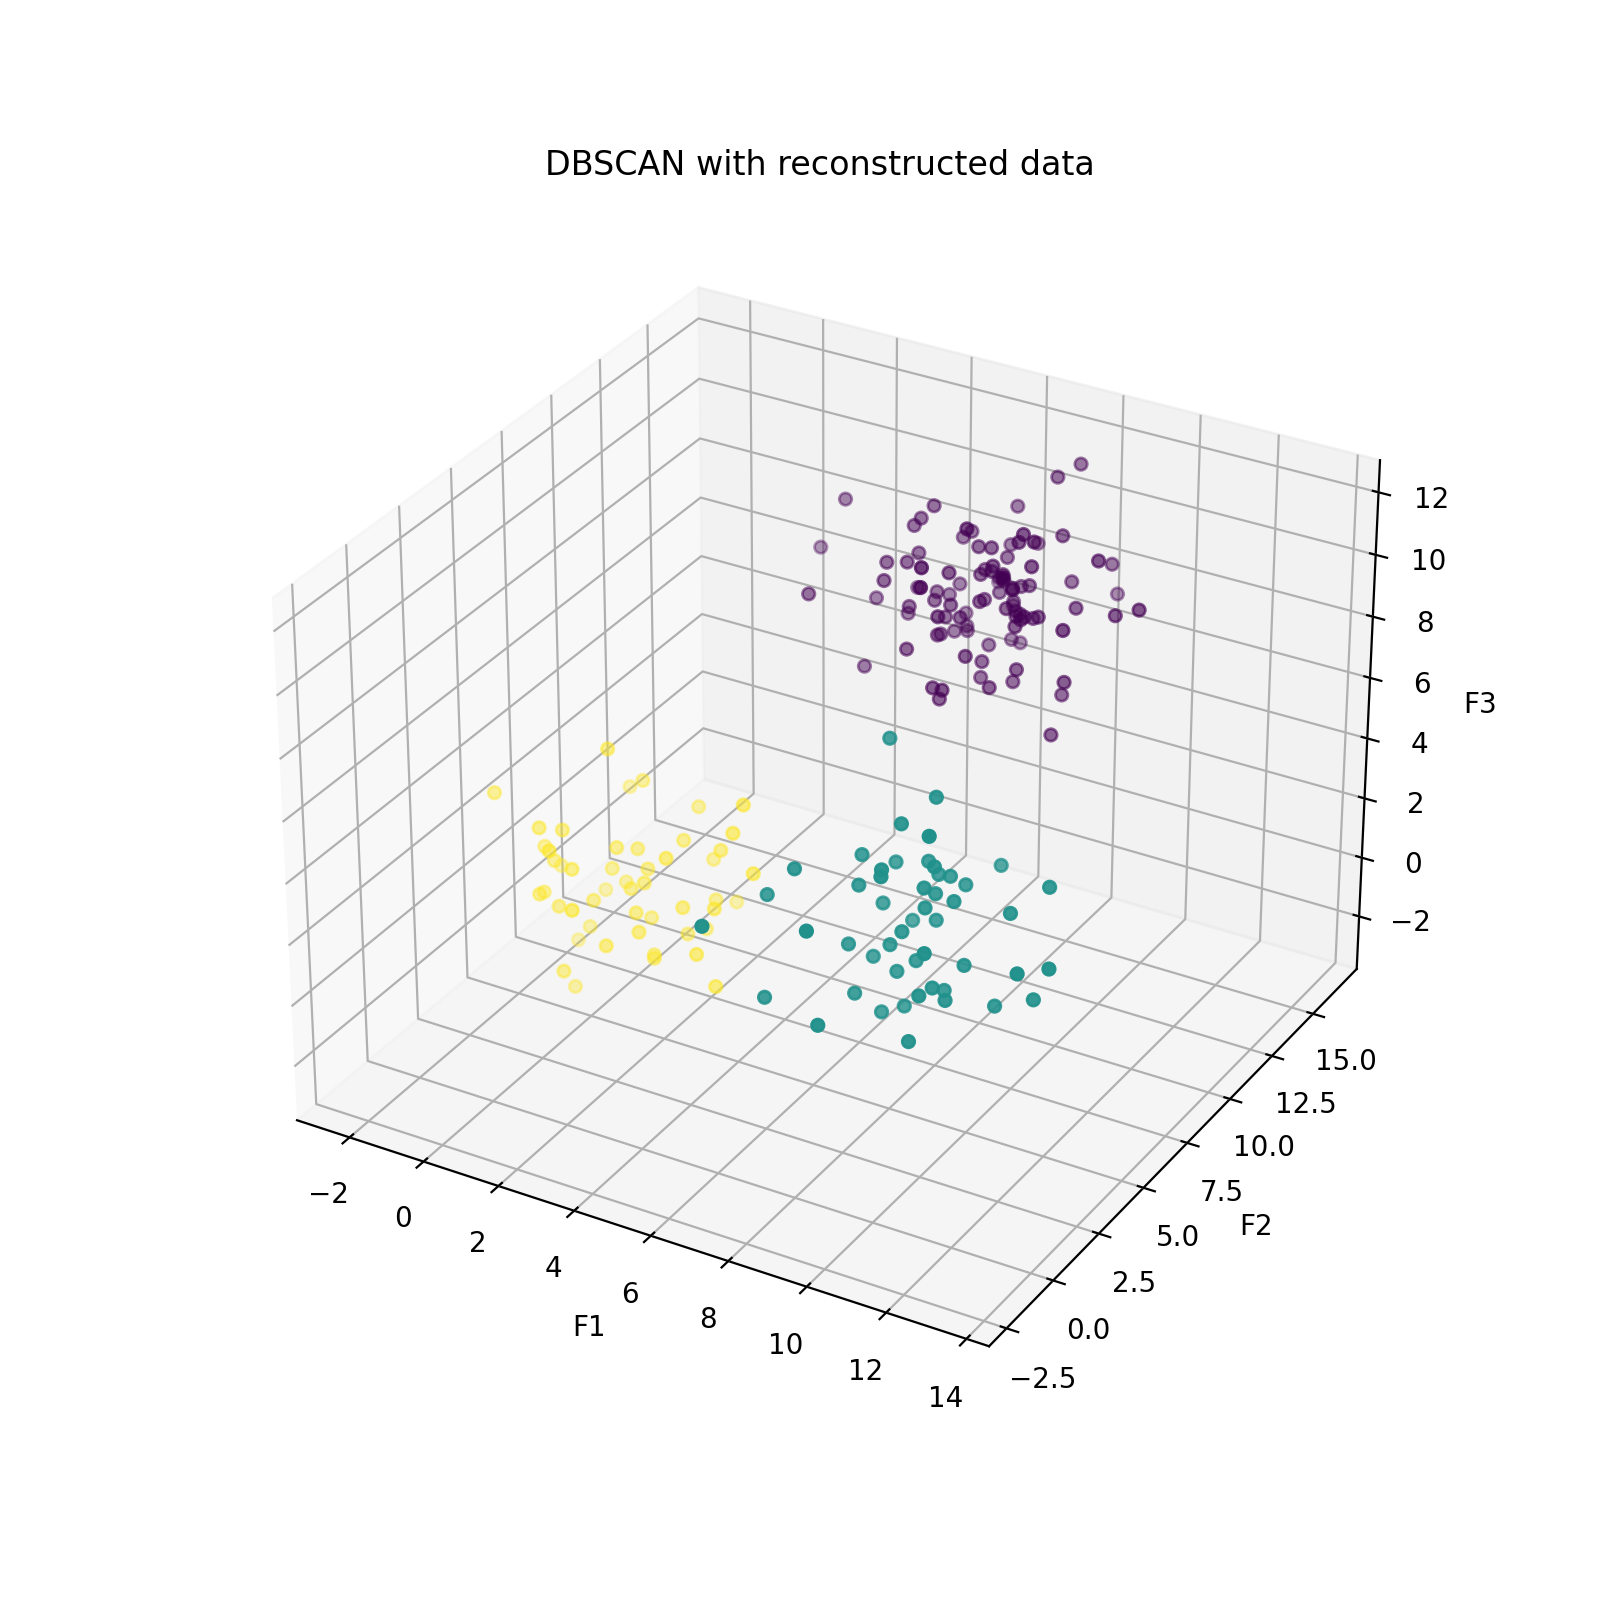

In [10]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "1_DBSCAN_original_data.png"), **config["plots"])

In [13]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [14]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error
import astropy.stats

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = rmse + KLdl + cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [16]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
features_reconstr = []
costs = {}
output["runtimes"] = {}

for run in range(config["RQ2"]["runs"]):
    time_start = time.time()
    features_reconstr.append(features_mv.copy())
    costs[run] = []
    for feature in features_to_predict:
        print(f"Run {run+1}, predicting {feature}")

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil(config["RQ2"]["pred_features"] * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as defined in config (missing_value_mask)
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(config["general"]["missing_value_mask"])
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, train_size=config["training"]["train_val_split"])

        # create & train model
        model = TabNetRegressor(**regressor_param)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            **config["model_param"],
            cluster_means=cluster_means,
            target_feature=feature,
            x_val=x_val,
            y_val=y_val,
        )

        #track runtime
        time_end = time.time()
        
        # add costs to dict
        costs[run].append(model.best_cost)
        

        # fill missing values with model predictions
        features_reconstr[run].loc[features_reconstr[run][feature].isna(), feature] = [x[0] for x in model.predict(test_data)]

        # save outputs
        if save_output:
            
            # save model
            torch.save(model, os.path.join(models_path, f"Model_run{run}_{feature}.pt"))
            
            # save runtimes
            output["runtimes"][f"run{run}_{feature}"] = time_end - time_start


Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
epoch 0  | loss: 47.13253| val_0_custom_loss: 1886.02164|  0:00:00s
epoch 1  | loss: 22.30458| val_0_custom_loss: 1476.40988|  0:00:00s
epoch 2  | loss: 13.49818| val_0_custom_loss: 1420.51707|  0:00:00s
epoch 3  | loss: 9.14184 | val_0_custom_loss: 1227.027|  0:00:00s
epoch 4  | loss: 7.68392 | val_0_custom_loss: 1033.5291|  0:00:00s
epoch 5  | loss: 6.52074 | val_0_custom_loss: 1045.57603|  0:00:00s
epoch 6  | loss: 5.56721 | val_0_custom_loss: 1103.6458|  0:00:00s
epoch 7  | loss: 5.52244 | val_0_custom_loss: 1145.29612|  0:00:00s
epoch 8  | loss: 5.04335 | val_0_custom_loss: 1210.00396|  0:00:00s
epoch 9  | loss: 5.93738 | val_0_custom_loss: 1206.91586|  0:00:00s
epoch 10 | loss: 5.57973 | val_0_custom_loss: 1120.33602|  0:00:00s
epoch 11 | loss: 4.46102 | val_0_custom_loss: 1109.30588|  0:00:00s
epoch 12 | loss: 4.70752 | val_0_custom_loss: 1130.55776|  0:00:00s
epoch 13 | loss: 4.15539 | val_0_custo

epoch 121| loss: 3.19328 | val_0_custom_loss: 119.33344|  0:00:06s
epoch 122| loss: 2.81926 | val_0_custom_loss: 118.96498|  0:00:06s
epoch 123| loss: 2.88989 | val_0_custom_loss: 118.55192|  0:00:06s
epoch 124| loss: 3.56604 | val_0_custom_loss: 118.17467|  0:00:06s
epoch 125| loss: 3.99485 | val_0_custom_loss: 117.88115|  0:00:06s
epoch 126| loss: 2.85758 | val_0_custom_loss: 117.51517|  0:00:06s
epoch 127| loss: 2.89736 | val_0_custom_loss: 117.1425|  0:00:06s
epoch 128| loss: 4.45656 | val_0_custom_loss: 116.75023|  0:00:06s
epoch 129| loss: 3.78775 | val_0_custom_loss: 116.3538|  0:00:06s
epoch 130| loss: 3.06943 | val_0_custom_loss: 116.02502|  0:00:06s
epoch 131| loss: 2.88587 | val_0_custom_loss: 115.68932|  0:00:06s
epoch 132| loss: 3.26728 | val_0_custom_loss: 115.33266|  0:00:06s
epoch 133| loss: 3.33815 | val_0_custom_loss: 114.96382|  0:00:06s
epoch 134| loss: 3.63828 | val_0_custom_loss: 114.65777|  0:00:07s
epoch 135| loss: 3.21966 | val_0_custom_loss: 114.35783|  0:00:0

epoch 29 | loss: 2.32249 | val_0_custom_loss: 296.71496|  0:00:01s
epoch 30 | loss: 2.54701 | val_0_custom_loss: 294.77072|  0:00:01s
epoch 31 | loss: 2.73337 | val_0_custom_loss: 290.73153|  0:00:01s
epoch 32 | loss: 2.46883 | val_0_custom_loss: 285.46273|  0:00:01s
epoch 33 | loss: 2.43314 | val_0_custom_loss: 280.17645|  0:00:01s
epoch 34 | loss: 2.36892 | val_0_custom_loss: 276.21405|  0:00:01s
epoch 35 | loss: 2.33392 | val_0_custom_loss: 272.87246|  0:00:01s
epoch 36 | loss: 2.40448 | val_0_custom_loss: 270.69377|  0:00:01s
epoch 37 | loss: 2.28986 | val_0_custom_loss: 269.13933|  0:00:01s
epoch 38 | loss: 2.46274 | val_0_custom_loss: 267.87673|  0:00:02s
epoch 39 | loss: 2.85525 | val_0_custom_loss: 267.56898|  0:00:02s
epoch 40 | loss: 2.30763 | val_0_custom_loss: 267.11276|  0:00:02s
epoch 41 | loss: 2.35552 | val_0_custom_loss: 266.10883|  0:00:02s
epoch 42 | loss: 2.2676  | val_0_custom_loss: 265.13386|  0:00:02s
epoch 43 | loss: 2.99114 | val_0_custom_loss: 264.2803|  0:00:

## 3. Complete Dataset
Costs for each run

In [14]:
costs

{0: [173.13399624746583, 296.3400975871688]}

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [15]:
cost_totals = [sum([x**2 for x in c]) for _, c in costs.items()]
best_model = cost_totals.index(min(cost_totals))
features_best = features_reconstr[best_model]
print(f"Best model: run {best_model} with custom losses {costs[best_model]} for features {list(features_to_predict)}")

Best model: run 0 with custom losses [173.13399624746583, 296.3400975871688] for features ['F2', 'F3']


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


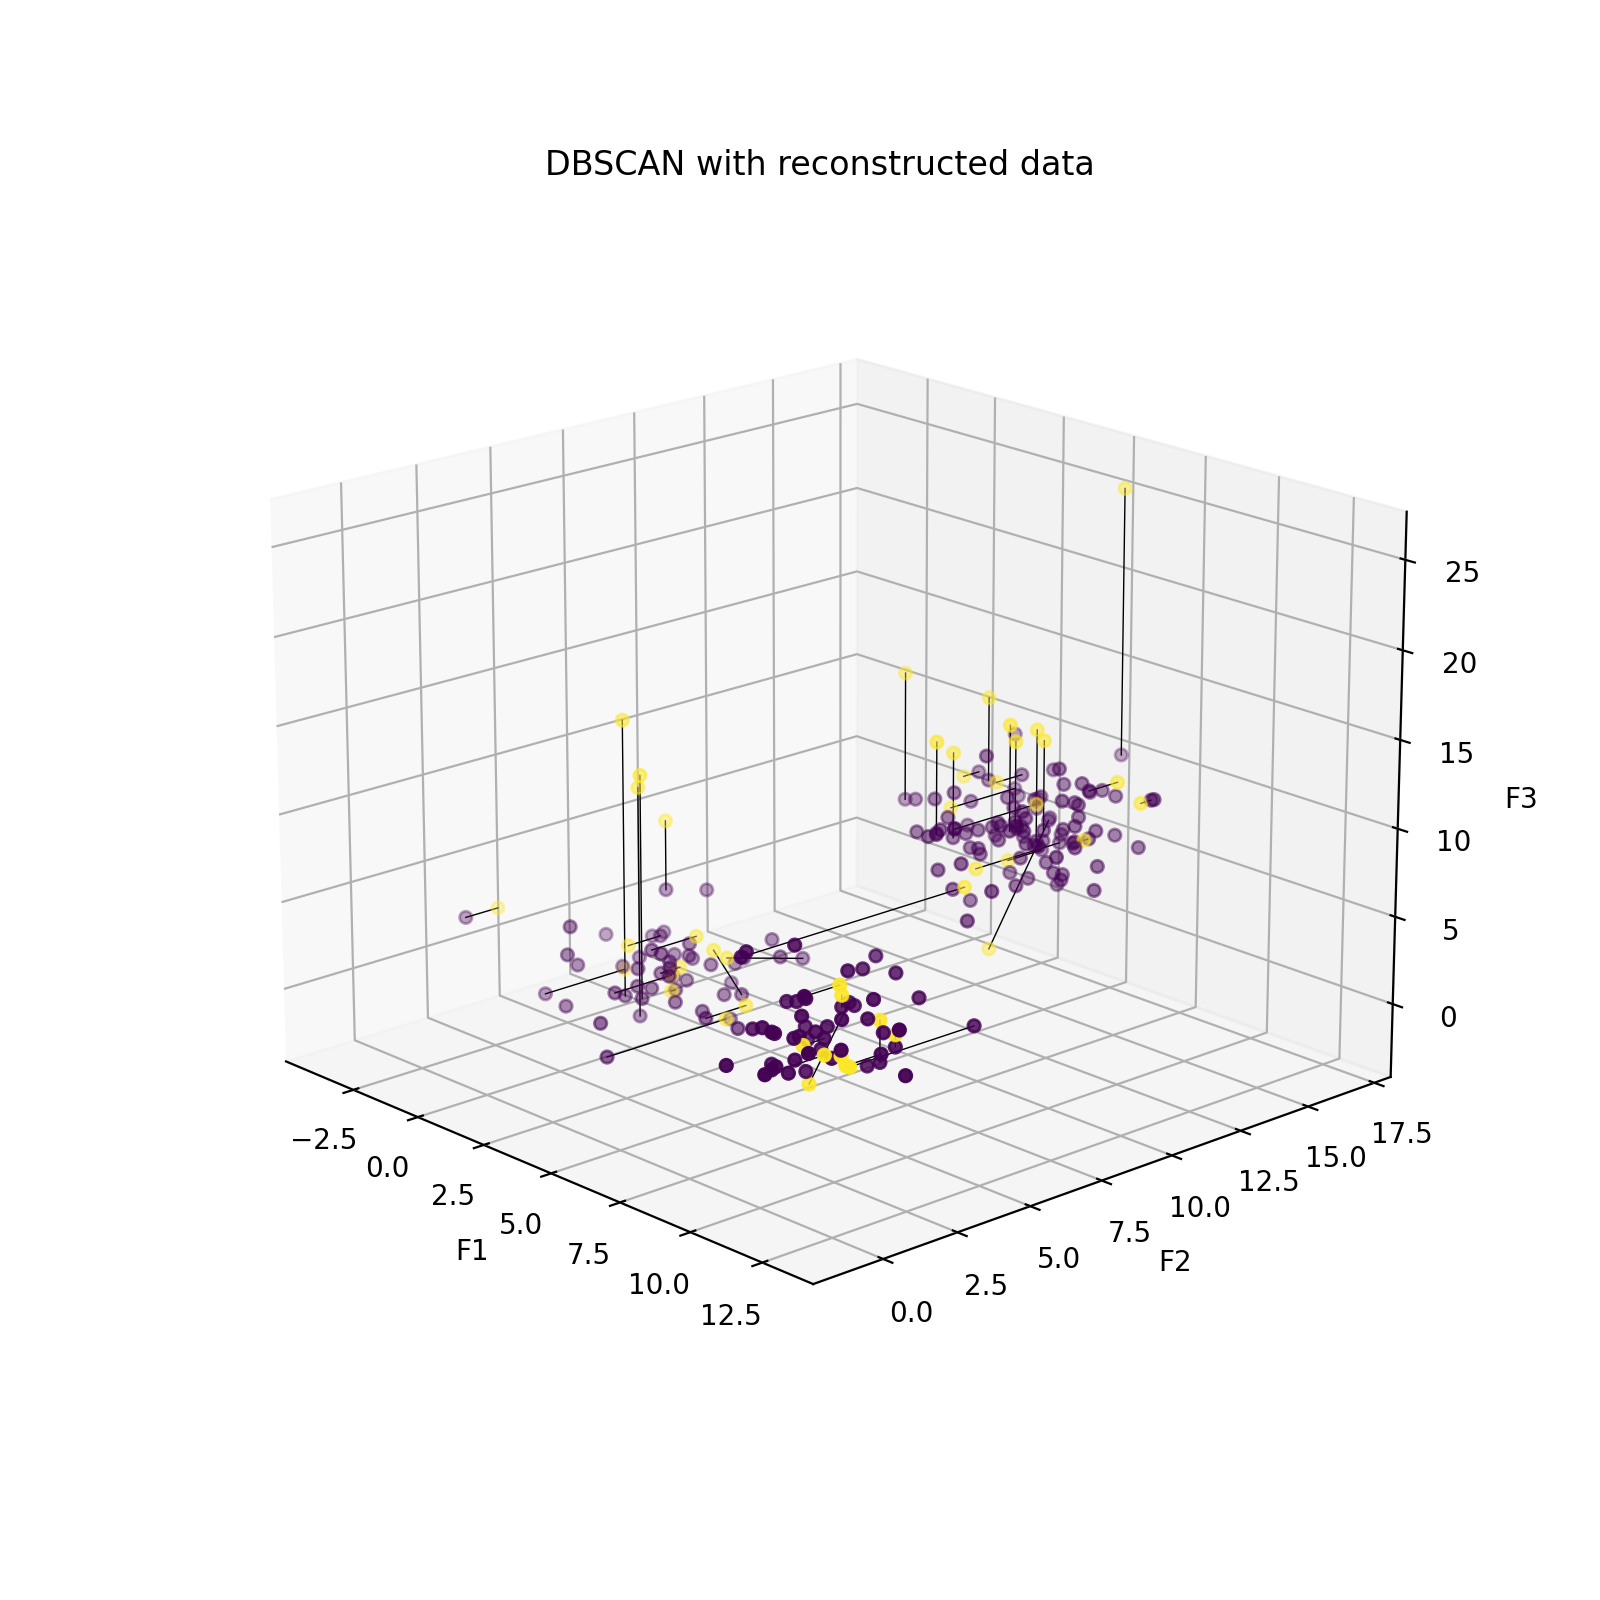

In [16]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_best[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_best[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show
if save_output:
    plt.savefig(os.path.join(plots_path, "4_imputation_differences.png"), **config["plots"])

## 4. Clustering

In [17]:
# apply clustering
clusters_reconstr = []
for run in range(config["RQ2"]["runs"]):
    dbscan_reconstr = DBSCAN(**config["DBSCAN"]).fit(features_reconstr[run])
    clusters_reconstr.append(dbscan_reconstr.labels_)

### 4.1. Plot of clustering based on best model predictions

<IPython.core.display.Javascript object>


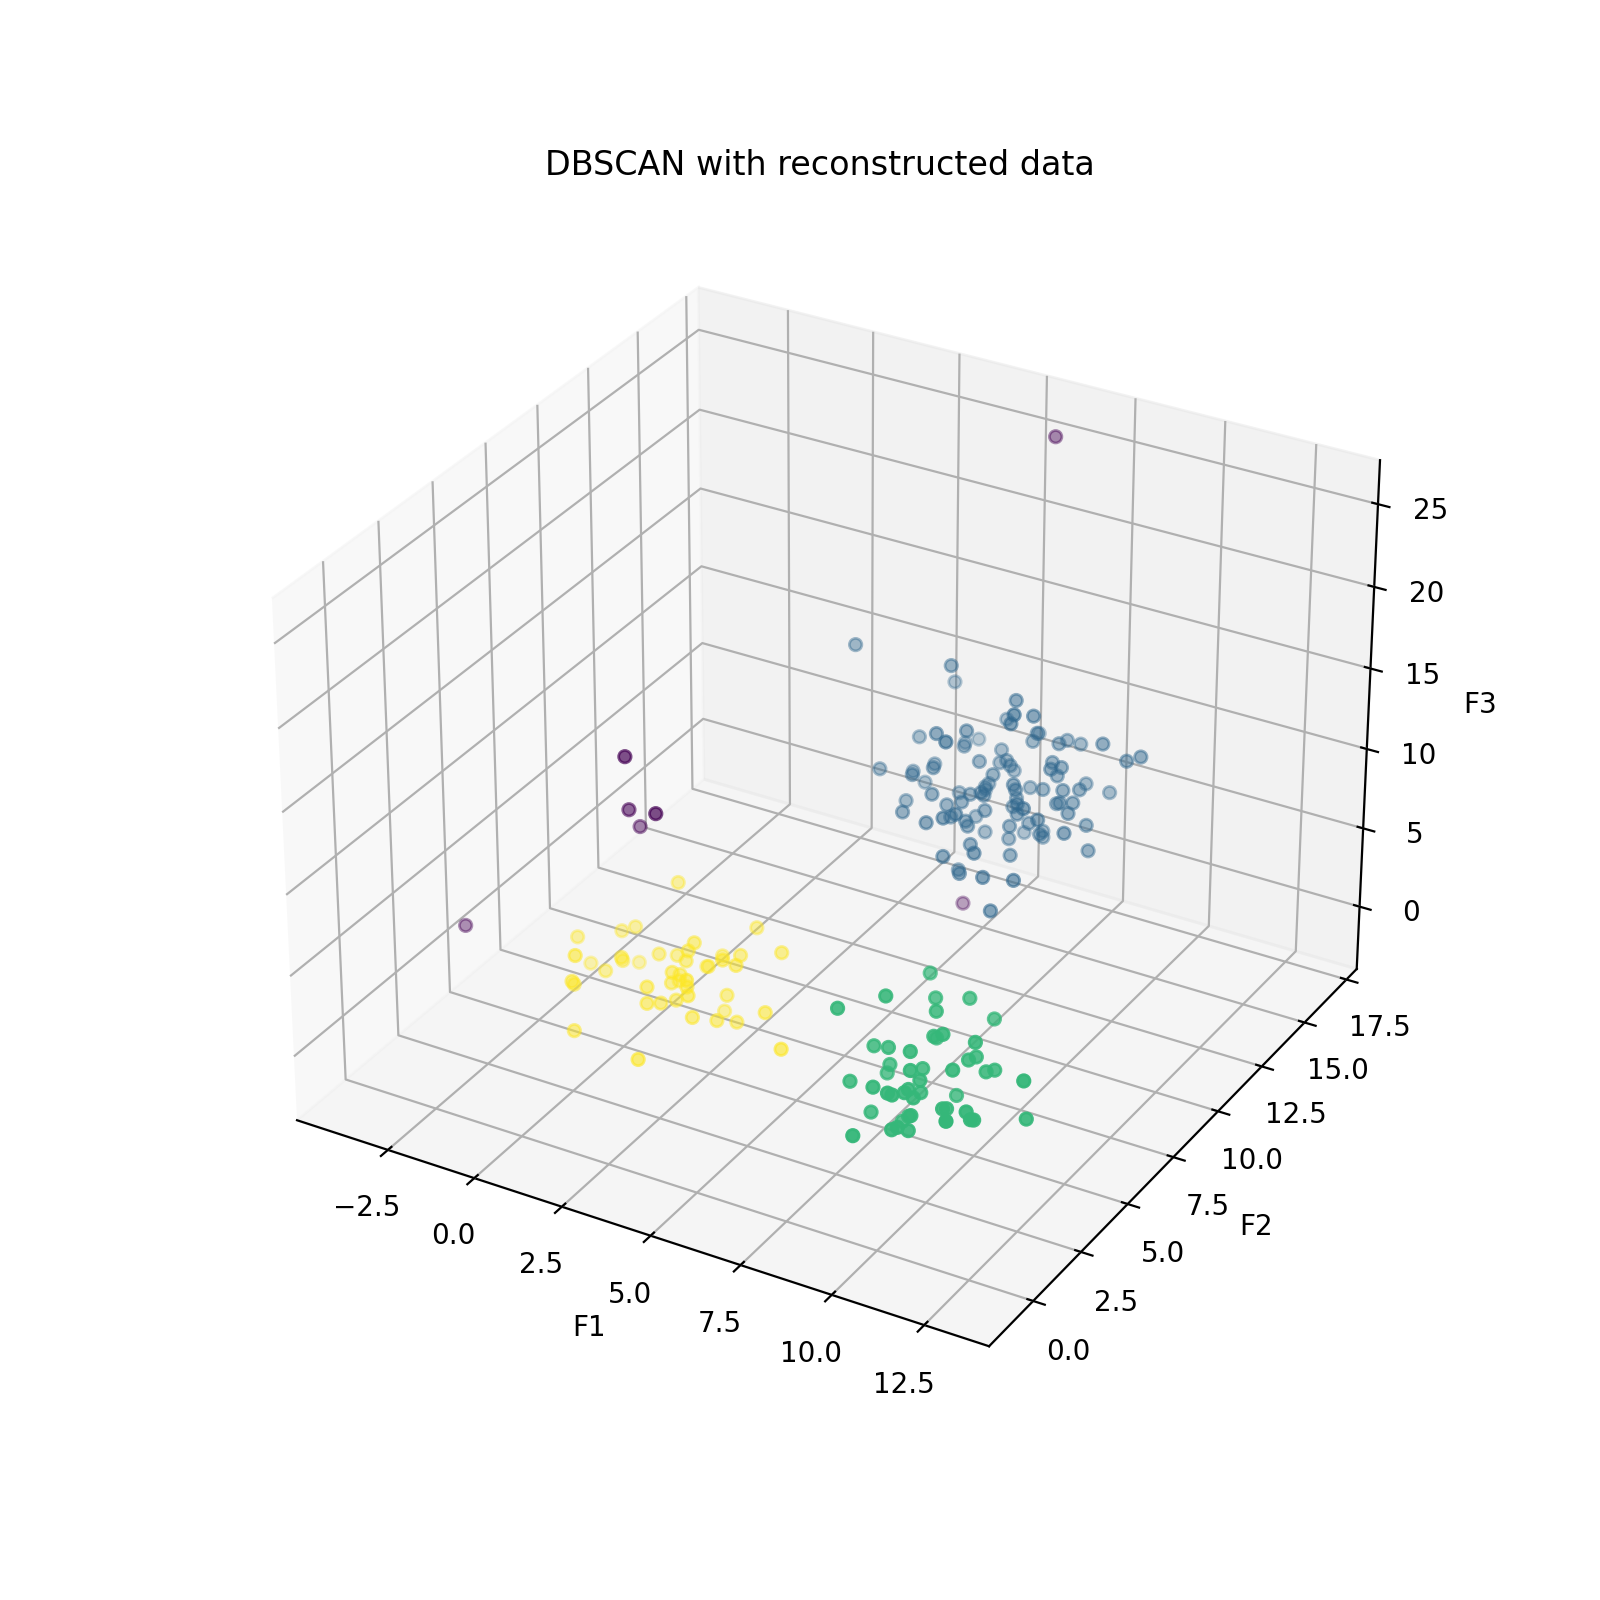

In [18]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_reconstr[0].iloc[:, 0], features_reconstr[0].iloc[:, 1], features_reconstr[0].iloc[:, 2], c=clusters_reconstr[0])
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "3_DBSCAN_imputed_data.png"), **config["plots"])

## 5. Cluster Performance


### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots based on best model predictions

<IPython.core.display.Javascript object>


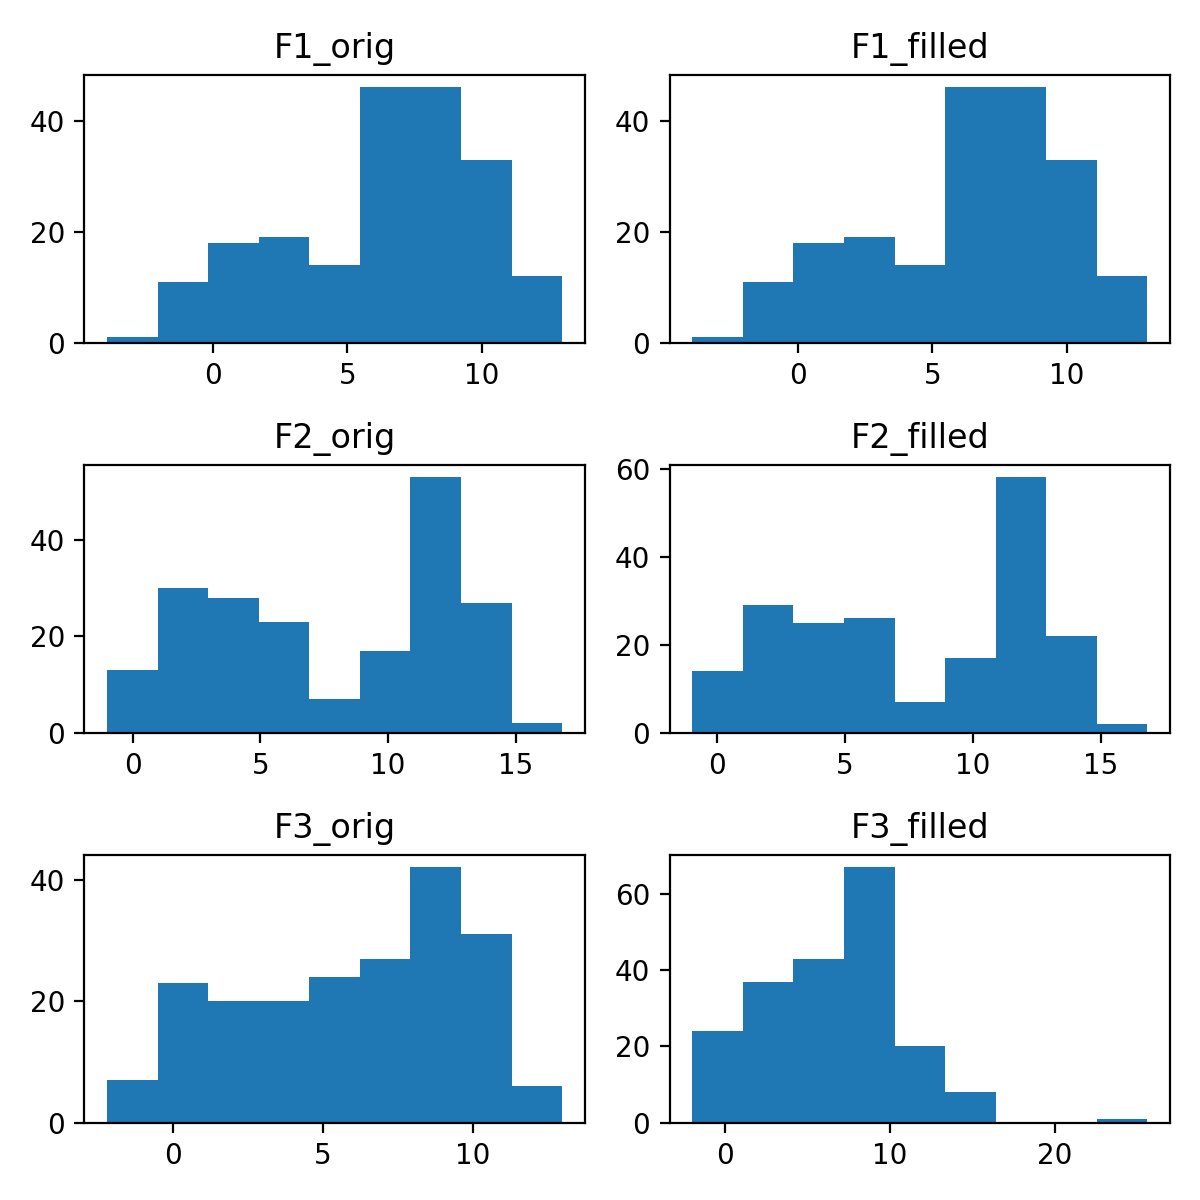

In [19]:
# plot distributions
bins = len(astropy.stats.freedman_bin_width(features[feature], return_bins=True)[1])
n_feat = len(features_best.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_best.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])

#### 5.1.2 KL Divergence

In [20]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [21]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["RQ2"]["runs"]):
    for feature in features_to_predict:
        output["kl_divergence"][f"run{run}_{feature}"] = kl_divergence(features[feature], features_reconstr[run][feature])

In [22]:
# plot

### 5.2 Silhouette Score

In [23]:
from sklearn.metrics import silhouette_score

output["silhouette_scores"] = {}
output["silhouette_scores"]["orig_data"] = float(silhouette_score(features, np.ravel(clusters)))

for run in range(config["RQ2"]["runs"]):
    output["silhouette_scores"][f"run{run}"] = float(silhouette_score(features_reconstr[run], clusters_reconstr[run]))

In [24]:
# plot

### 5.3. Outlierness
#### 5.3.1 Global outliers (considering all features)

In [41]:
# Outliers detected as noise by DBSCAN
output["cluster_noise"] = {}
output["cluster_noise"][f"orig_data"] = sum(clusters_orig == -1)

for run in range(config["RQ2"]["runs"]):
        output["cluster_noise"][f"run{run}"] = sum(clusters_reconstr[run] == -1)

#### 5.3.1 Local outliers (outlierness within one feature)

In [42]:
# plot global

# plot local

### 5.4. Save Output

In [43]:
with open(output_path, "w") as f:
            toml.dump(output, f)

In [44]:
output

{'runtimes': {'run0_F2': 11.906113862991333, 'run0_F3': 14.053078889846802},
 'kl_divergence': {'run0_F2': 0.002014879755740267,
  'run0_F3': 0.7295411615642836},
 'silhouette_scores': {'orig_data': 0.6940492238030105,
  'run0': 0.648936720558289},
 'cluster_noise': {'orig_data': 1, 'run0': 7}}